# VAE

Auteurs : Lisa Giordani, Mouïn Ben Ammar, Yoldoz Tabei, Ilias Harkati (Groupe 6)

Cours : Projet IA (IA321)

Projet : Génération d'images (P13)

Date : Mars 2022

Ce code vise à générer de nouvelles images à partir du dataset CIFAR10. Pour ce faire, on utilise un VAE.


## Import packages

In [2]:
! pip list | grep pytorch

pytorch-ignite                        0.4.8
pytorch-lightning                     1.4.4
pytorch-lightning-bolts               0.2.5


In [21]:
%%capture
! pip install pytorch-lightning==1.4.4
! pip install pytorch-lightning-bolts==0.2.5

In [22]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import resnet18_decoder,resnet18_encoder

## Model

In [6]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        self.mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        self.std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(self.mu, self.std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, self.mu, self.std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

## Data

On va utiliser la dataset CIFAR10 composé de 60 000 images de taille 32x32.

In [23]:
%%capture
! pip install pytorch-lightning-bolts==0.3.2

In [26]:
from pl_bolts.datamodules.cifar10_datamodule import CIFAR10DataModule
data = CIFAR10DataModule('.', batch_size=32)

## Training

In [18]:
%%time
from pytorch_lightning.loggers import TensorBoardLogger

pl.seed_everything(1234)

vae = VAE()
logger = TensorBoardLogger("lightning_logs/")
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=10, logger=logger)
history = trainer.fit(vae, data)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: -1it [00:00, ?it/s]

CPU times: user 14min 46s, sys: 47.3 s, total: 15min 33s
Wall time: 16min 15s


## Image generation

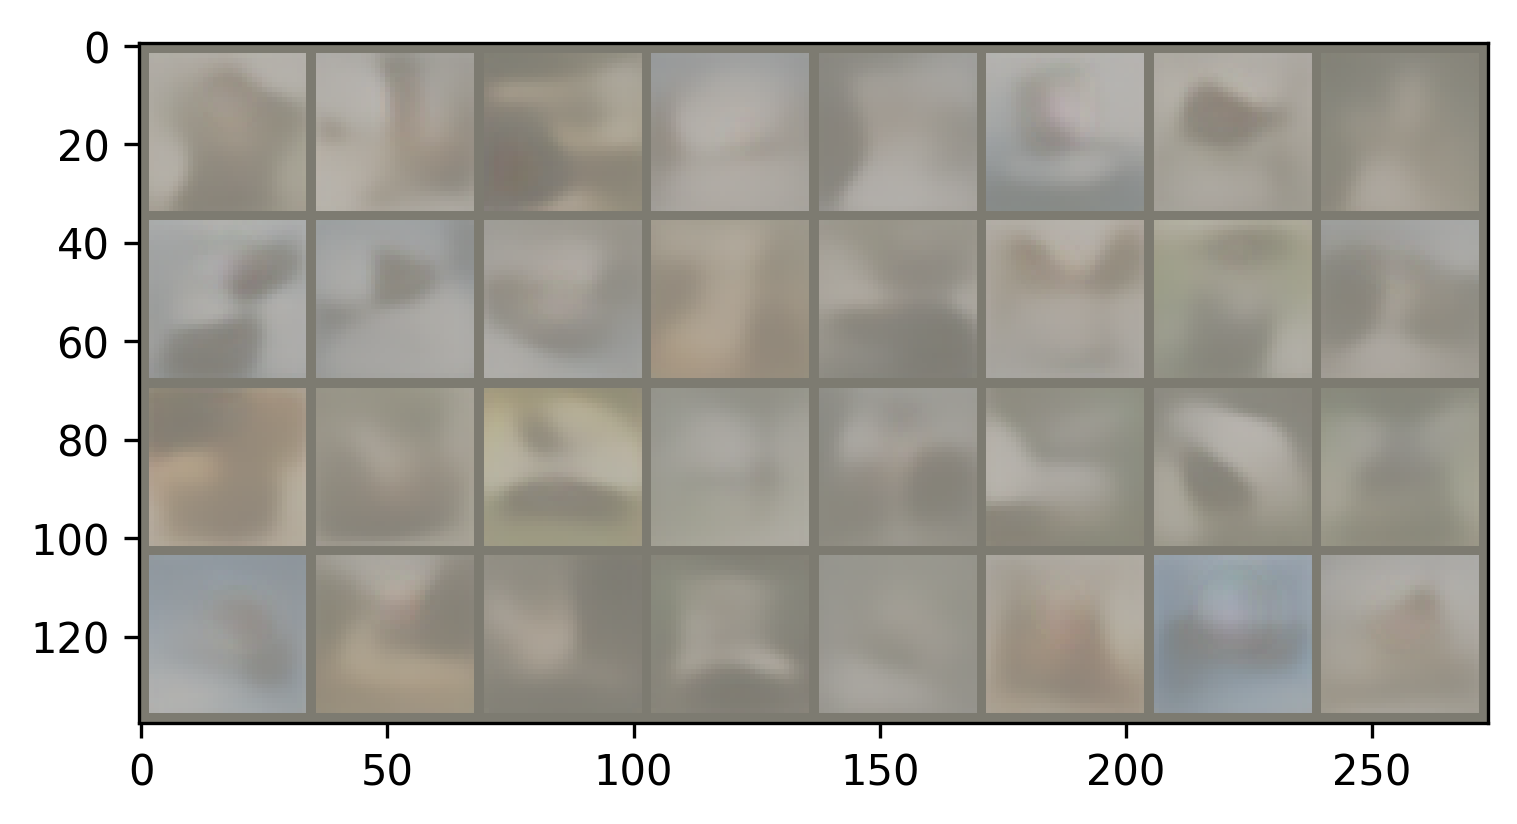

In [19]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

num_preds = 32

# Z COMES FROM NORMAL(0, 1)
mu = torch.zeros((1,256))
std = torch.ones((1,256))
p = torch.distributions.Normal(mu, std)
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);